In [0]:
# Install Chainer and CuPy!

!apt -y install libcusparse8.0 libnvrtc8.0 libnvtoolsext1
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!pip install https://github.com/kmaehashi/chainer-colab/releases/download/2018-02-06/cupy_cuda80-4.0.0b3-cp36-cp36m-linux_x86_64.whl
!pip install 'chainer==4.0.0b3'

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  libcusparse8.0 libnvrtc8.0 libnvtoolsext1
0 upgraded, 3 newly installed, 0 to remove and 4 not upgraded.
Need to get 28.9 MB of archives.
After this operation, 71.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu artful/multiverse amd64 libcusparse8.0 amd64 8.0.61-1 [22.6 MB]
Get:2 http://archive.ubuntu.com/ubuntu artful/multiverse amd64 libnvrtc8.0 amd64 8.0.61-1 [6,225 kB]
Get:3 http://archive.ubuntu.com/ubuntu artful/multiverse amd64 libnvtoolsext1 amd64 8.0.61-1 [32.2 kB]
Fetched 28.9 MB in 1s (16.2 MB/s)

78Selecting previously unselected package libcusparse8.0:amd64.
(Reading database ... 16633 files and directories currently installed.)
Preparing to unpack .../libcusparse8.0_8.0.61-1_amd64.deb ...
7Progress: [  0%] [..........................................................] 87Progress: [  6%] [###..

In [1]:
import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
from chainer.datasets import mnist
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

In [2]:
print('GPU availability:', chainer.cuda.available)
print('cuDNN availablility:', chainer.cuda.cudnn_enabled)

GPU availability: True
cuDNN availablility: True


In [3]:
train, test = mnist.get_mnist()

batchsize = 128

train_iter = iterators.SerialIterator(train, batchsize)
test_iter = iterators.SerialIterator(test, batchsize, False, False)

In [4]:
class MLP(Chain):

    def __init__(self, n_mid_units=100, n_out=10):
        super(MLP, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, n_mid_units)
            self.l2 = L.Linear(None, n_mid_units)
            self.l3 = L.Linear(None, n_out)

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)

model = MLP()

In [21]:
max_epoch = 10

model = L.Classifier(model)

gpu_id = 0  # Set to -1 if you use CPU
if gpu_id >= 0:
    model.to_gpu(gpu_id)  # If you use CPU, comment out this line

# selection of your optimizing method
optimizer = optimizers.MomentumSGD()

# Give the optimizer a reference to the model
optimizer.setup(model)

# Get an updater that uses the Iterator and Optimizer
updater = training.StandardUpdater(train_iter, optimizer, device=gpu_id)

# Setup a Trainer
trainer = training.Trainer(updater, (max_epoch, 'epoch'), out='mnist_result')

In [22]:
trainer.extend(extensions.LogReport())
trainer.extend(extensions.snapshot(filename='snapshot_epoch-{.updater.epoch}'))
trainer.extend(extensions.snapshot_object(model.predictor, filename='model_epoch-{.updater.epoch}'))
trainer.extend(extensions.Evaluator(test_iter, model, device=gpu_id))
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'main/accuracy', 'validation/main/loss', 'validation/main/accuracy', 'elapsed_time']))
trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'], x_key='epoch', file_name='loss.png'))
trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
trainer.extend(extensions.dump_graph('main/loss'))

In [23]:
trainer.run()

epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy  elapsed_time
1           0.570037    0.835821       0.273419              0.920194                  3.6953        
2           0.238146    0.930687       0.200935              0.940665                  6.52569       
3           0.17904     0.948228       0.153941              0.953619                  9.3238        
4           0.142458    0.958684       0.130232              0.960542                  12.1489       
5           0.118986    0.965085       0.118132              0.964794                  15.1986       
6           0.103165    0.969949       0.103958              0.969343                  18.2002       
7           0.0897281   0.973881       0.0965577             0.970827                  20.9793       
8           0.0797545   0.976512       0.0935598             0.971222                  23.8733       
9           0.0711605   0.979261       0.088409              0.971717               

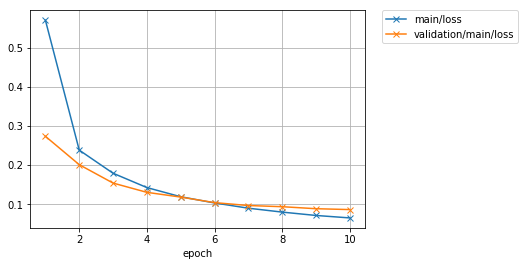

In [41]:
from IPython.display import Image
Image('mnist_result/loss.png')

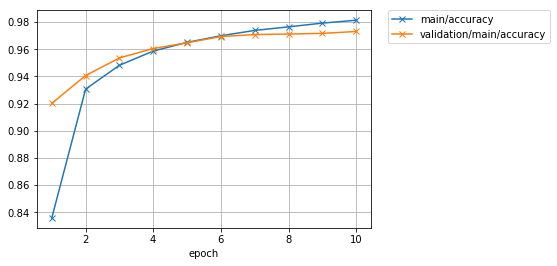

In [42]:
Image('mnist_result/accuracy.png')

label: 2
inference: 2


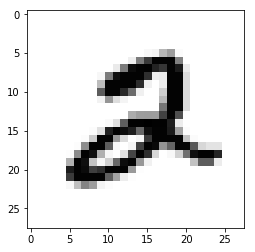

In [79]:
from IPython.display import display
model.to_cpu()
"""
学習済みモデルを使って、推論をしてみる。
serializers.save_npz('my_mnist.model',model)
"""

img_flattened, label = train[5]
img_reshaped = img_flattened.reshape(28,28)
plt.imshow(img_reshaped ,cmap='Greys')
print('label: %s' % label)

res_var = model.predictor(img_flattened.reshape(1,28*28))
res     = res_var.data.argmax()
print('inference: %s' % res)

float32
inference: 7


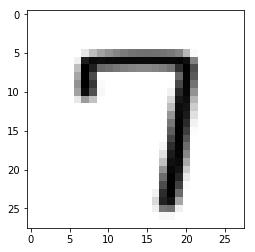

In [81]:
from PIL import Image
my_test = Image.open('7_28x28.png').convert('L')
my_test_arr = np.asarray(my_test)
my_test_arr = (1 - my_test_arr/255).astype('float32')
print(my_test_arr.dtype)
plt.imshow(my_test_arr, cmap='Greys')
res_var = model.predictor(my_test_arr.reshape(1,28*28))
res     = res_var.data.argmax()
print('inference: %s' % res)

In [80]:
model?